---
title: "Activity 9.2"
format:
  html:
    embed-resources: true
    code-fold: true
execute:
  echo: true
  warning: false
  message: false
---


Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [8]:
## library imports here
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [9]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [10]:
X = ha.drop(columns=['cp'])
y = ha['cp']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("First 5 rows of X:\n", X.head())
print("First 5 values of y:\n", y.head())

Shape of X: (273, 7)
Shape of y: (273,)
First 5 rows of X:
    age  sex  trtbps  chol  restecg  thalach  output
0   63    1     145   233        0      150       1
1   37    1     130   250        1      187       1
2   56    1     120   236        1      178       1
3   57    0     120   354        1      163       1
4   57    1     140   192        1      148       1
First 5 values of y:
 0    3
1    2
2    1
3    0
4    0
Name: cp, dtype: int64


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [12]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Instantiate KNeighborsClassifier
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': range(1, 21)}

# Set up StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=skf, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the data
grid_search_knn.fit(X, y)

# Print the best parameters and best score
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best cross-validation accuracy for KNN:", grid_search_knn.best_score_)

Best parameters for KNN: {'n_neighbors': 8}
Best cross-validation accuracy for KNN: 0.4617508417508417


In [13]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Define the parameter grid for max_depth
param_grid_dt = {'max_depth': range(1, 21)}

# Instantiate GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=skf, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the data
grid_search_dt.fit(X, y)

# Print the best parameters and best score
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best cross-validation accuracy for Decision Tree:", grid_search_dt.best_score_)

Best parameters for Decision Tree: {'max_depth': 1}
Best cross-validation accuracy for Decision Tree: 0.5747474747474748


In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

# Instantiate LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

# Perform cross-validation
cv_scores_lda = cross_val_score(estimator=lda, X=X, y=y, cv=skf, scoring='accuracy', n_jobs=-1)

# Print the mean and standard deviation of the cross-validation accuracy scores
print(f"Mean cross-validation accuracy for LDA: {cv_scores_lda.mean():.4f}")
print(f"Standard deviation of cross-validation accuracy for LDA: {cv_scores_lda.std():.4f}")

Mean cross-validation accuracy for LDA: 0.5601
Standard deviation of cross-validation accuracy for LDA: 0.0400


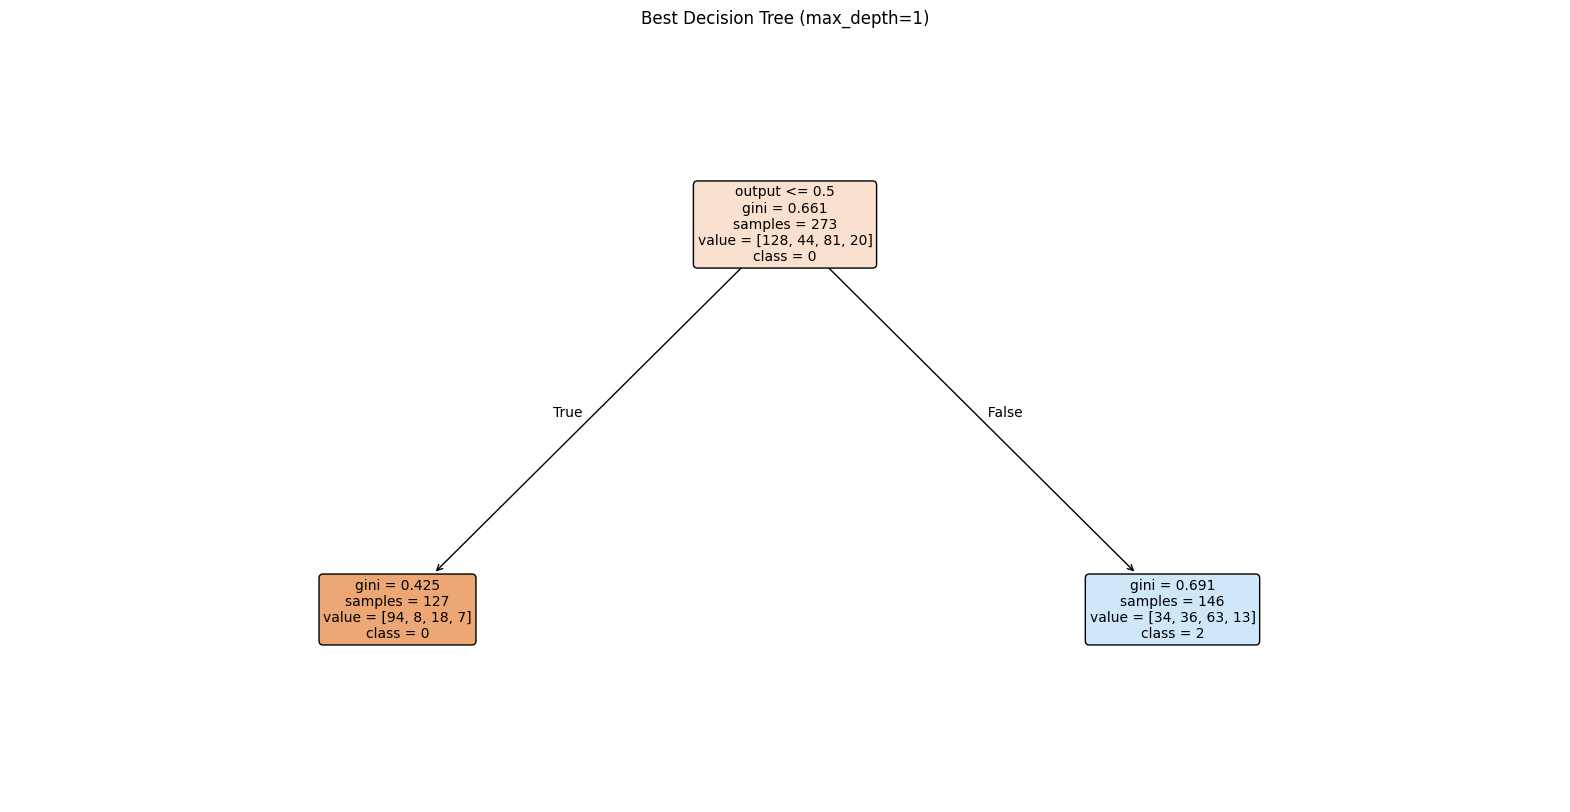

In [16]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Get the best Decision Tree estimator
best_dt_model = grid_search_dt.best_estimator_

# Get feature names and class names
feature_names = X.columns.tolist()
class_names = [str(c) for c in sorted(y.unique())]

# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt_model,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Best Decision Tree (max_depth=1)")
plt.show()



We found a max depth of 1 through searching for the best setp so this is the only output it gives us


If thalach <= 149.5 it goes to the left section, this branch corresponds to a group of patients where the majority class is Chest Pain Type 0 (asymptomatic), with a significant number of samples belonging to this type.

If thalach > 149.5 which is the right section, This branch corresponds to patients with a higher maximum heart rate achieved. In this group, Chest Pain Type 1 (typical angina) appears to be the majority class.

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [25]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

# Create binary target for cp == 3
ha['cp_is_3'] = (ha['cp'] == 3).astype(int)

# Fit Logistic Regression for cp == 3
X = ha.drop(columns=['cp', 'cp_is_3'])
y_3 = ha['cp_is_3']

lr_3 = LogisticRegression(max_iter=1000, random_state=42)
lr_3.fit(X, y_3)

# Get predictions using cross-validation for better evaluation
y_pred_3 = cross_val_predict(lr_3, X, y_3, cv=5)
f1_3 = f1_score(y_3, y_pred_3)

print(f"F1 Score for cp == 3 (non-anginal pain): {f1_3:.4f}")

# Repeat for cp == 0
ha['cp_is_0'] = (ha['cp'] == 0).astype(int)
y_0 = ha['cp_is_0']

lr_0 = LogisticRegression(max_iter=1000, random_state=42)
lr_0.fit(X, y_0)
y_pred_0 = cross_val_predict(lr_0, X, y_0, cv=5)
f1_0 = f1_score(y_0, y_pred_0)

print(f"F1 Score for cp == 0 (asymptomatic): {f1_0:.4f}")

# Repeat for cp == 1
ha['cp_is_1'] = (ha['cp'] == 1).astype(int)
y_1 = ha['cp_is_1']

lr_1 = LogisticRegression(max_iter=1000, random_state=42)
lr_1.fit(X, y_1)
y_pred_1 = cross_val_predict(lr_1, X, y_1, cv=5)
f1_1 = f1_score(y_1, y_pred_1)

print(f"F1 Score for cp == 1 (typical angina): {f1_1:.4f}")

# Repeat for cp == 2
ha['cp_is_2'] = (ha['cp'] == 2).astype(int)
y_2 = ha['cp_is_2']

lr_2 = LogisticRegression(max_iter=1000, random_state=42)
lr_2.fit(X, y_2)
y_pred_2 = cross_val_predict(lr_2, X, y_2, cv=5)
f1_2 = f1_score(y_2, y_pred_2)

print(f"F1 Score for cp == 2 (atypical angina): {f1_2:.4f}")

# Summary
print("\n" + "="*50)
print("SUMMARY OF F1 SCORES")
print("="*50)
f1_scores = {
    'cp == 0 (asymptomatic)': f1_0,
    'cp == 1 (typical angina)': f1_1,
    'cp == 2 (atypical angina)': f1_2,
    'cp == 3 (non-anginal pain)': f1_3
}

for category, score in sorted(f1_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{category}: {score:.4f}")

best_category = max(f1_scores, key=f1_scores.get)
print(f"\nThe OvR approach was best at distinguishing: {best_category}")

F1 Score for cp == 3 (non-anginal pain): 0.5714
F1 Score for cp == 0 (asymptomatic): 1.0000
F1 Score for cp == 1 (typical angina): 1.0000
F1 Score for cp == 2 (atypical angina): 1.0000

SUMMARY OF F1 SCORES
cp == 0 (asymptomatic): 1.0000
cp == 1 (typical angina): 1.0000
cp == 2 (atypical angina): 1.0000
cp == 3 (non-anginal pain): 0.5714

The OvR approach was best at distinguishing: cp == 0 (asymptomatic)


## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [29]:
from sklearn.metrics import roc_auc_score

# First, we need to reload X and y to get clean data without the extra columns
X = ha.drop(columns=['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'])
y = ha['cp']

# Compare cp 0 vs 1
ha_0_vs_1 = ha[ha['cp'].isin([0, 1])].copy()
X_0_vs_1 = ha_0_vs_1.drop(columns=['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'])
y_0_vs_1 = ha_0_vs_1['cp']

lr_0_vs_1 = LogisticRegression(max_iter=1000, random_state=42)
lr_0_vs_1.fit(X_0_vs_1, y_0_vs_1)

# Get predicted probabilities for the positive class
y_proba_0_vs_1 = cross_val_predict(lr_0_vs_1, X_0_vs_1, y_0_vs_1, cv=5, method='predict_proba')
roc_auc_0_vs_1 = roc_auc_score(y_0_vs_1, y_proba_0_vs_1[:, 1])

print(f"ROC-AUC for cp 0 vs 1 (asymptomatic vs typical angina): {roc_auc_0_vs_1:.4f}")

# Compare cp 0 vs 2
ha_0_vs_2 = ha[ha['cp'].isin([0, 2])].copy()
X_0_vs_2 = ha_0_vs_2.drop(columns=['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'])
y_0_vs_2 = ha_0_vs_2['cp']

lr_0_vs_2 = LogisticRegression(max_iter=1000, random_state=42)
lr_0_vs_2.fit(X_0_vs_2, y_0_vs_2)

y_proba_0_vs_2 = cross_val_predict(lr_0_vs_2, X_0_vs_2, y_0_vs_2, cv=5, method='predict_proba')
roc_auc_0_vs_2 = roc_auc_score(y_0_vs_2, y_proba_0_vs_2[:, 1])

print(f"ROC-AUC for cp 0 vs 2 (asymptomatic vs atypical angina): {roc_auc_0_vs_2:.4f}")

# Compare cp 0 vs 3
ha_0_vs_3 = ha[ha['cp'].isin([0, 3])].copy()
X_0_vs_3 = ha_0_vs_3.drop(columns=['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'])
y_0_vs_3 = ha_0_vs_3['cp']

lr_0_vs_3 = LogisticRegression(max_iter=1000, random_state=42)
lr_0_vs_3.fit(X_0_vs_3, y_0_vs_3)

y_proba_0_vs_3 = cross_val_predict(lr_0_vs_3, X_0_vs_3, y_0_vs_3, cv=5, method='predict_proba')
roc_auc_0_vs_3 = roc_auc_score(y_0_vs_3, y_proba_0_vs_3[:, 1])

print(f"ROC-AUC for cp 0 vs 3 (asymptomatic vs non-anginal pain): {roc_auc_0_vs_3:.4f}")

# Summary
roc_auc_scores = {
    'cp 0 vs 1 (asymptomatic vs typical angina)': roc_auc_0_vs_1,
    'cp 0 vs 2 (asymptomatic vs atypical angina)': roc_auc_0_vs_2,
    'cp 0 vs 3 (asymptomatic vs non-anginal pain)': roc_auc_0_vs_3
}


ROC-AUC for cp 0 vs 1 (asymptomatic vs typical angina): 0.7278
ROC-AUC for cp 0 vs 2 (asymptomatic vs atypical angina): 0.6655
ROC-AUC for cp 0 vs 3 (asymptomatic vs non-anginal pain): 0.6969


The The OvO approach was best at distinguishing: cp 0 vs 1 (asymptomatic vs typical angina)